Filter coefs: [0.29399155 0.38311672 0.32289173]
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 --- 19.52349267403285 minutes ---


<Figure size 432x288 with 0 Axes>

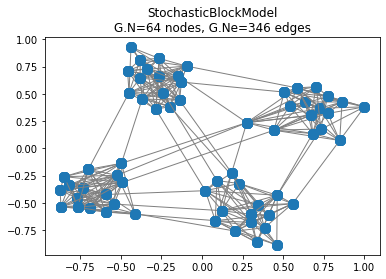

In [1]:
import sys
import copy
import time

import numpy as np
import torch
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.architecture import GraphDecoder
from graph_deep_decoder.model import Model

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

# Graph parameters
Gs = {}
Gs['type'] = ds.SBM
Gs['N'] = 64
Gs['k'] = 4
Gs['type_z'] = ds.CONT
Gs['p'] = 0.7
Gs['q'] = 0.015

# Signal parameters
K = 3
n_signals = 100
params = 4
n_p = 0.1

# Model parameters
epochs = 500
lr = 0.001

# Create graph
G = ds.create_graph(Gs, SEED)
A = G.W.todense()
plt.figure()
G.plot()

# Create filter H and decoder
hs = np.random.rand(K)
hs /= np.sum(hs)
print('Filter coefs:', hs)
x_dw = ds.DiffusedWhiteGS(G, ds.NonLin.NONE, K, coefs=hs)
H = x_dw.H
H /= np.linalg.norm(H)

# Prepare experiments
scales = [.1]
exps = [{'fts': 32, 'leg': '32N'},
        {'fts': 64, 'leg': '64N'},
        {'fts': 150, 'leg': '150N'},
        {'fts': 500, 'leg': '500N'},
        {'fts': 1000, 'leg': '1000N'},
        {'fts': 5000, 'leg': '5000N'}]
leg = [exp['leg'] for exp in exps]

# Fit models
err = np.zeros((len(scales), len(exps), n_signals, epochs, G.N))
err_wrt_n = np.zeros((len(scales), len(exps), n_signals, epochs, G.N))
weight_norm = np.zeros((len(scales), len(exps), n_signals))

start_time = time.time()
for i in range(n_signals):
    for k, ft_sc in enumerate(scales):
        for j, exp in enumerate(exps):
            if ft_sc is None:
                scale = .01
            else:
                scale = ft_sc/np.sqrt(exp['fts'])
            dec = GraphDecoder(exp['fts'], H, scale)
            weight_norm[k, j, i] = np.linalg.norm(dec.conv.weight.data.numpy().squeeze())
            # JJ = dec.analytical_squared_jacobian()
            Lambda, V = utils.ordered_eig(H)

            x = ds.bandlimited_signal(Lambda, V, params)
            
            #x_dw = ds.DiffusedWhiteGS(G, ds.NonLin.MEDIAN, K)
            #x_dw.to_unit_norm()
            #x = x_dw.x
            
            x_n = ds.GraphSignal.add_noise(x, n_p)
            model = Model(dec, epochs=epochs, learning_rate=lr)
            err_wrt_n[k, j, i, :, :], err[k, j, i, :, :], _ = model.fit(x_n, x, reduce_err=False)

    print(i, end=' ', flush=True)

print('--- {} minutes ---'.format((time.time()-start_time)/60))

[0.09989275 0.10015625 0.09996618 0.099983   0.10001416 0.10000018]


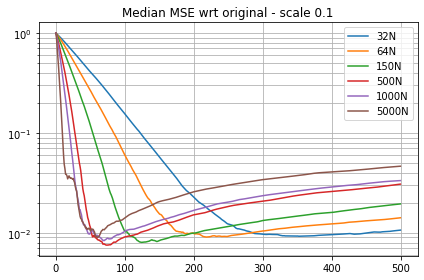

In [2]:
# Plots Median Error
for i, scale in enumerate(scales):
    print(np.mean(weight_norm[i], axis=1))
    
    med_mse = np.median(np.sum(err[i], axis=3), axis=1)
    plt.figure()
    plt.semilogy(med_mse.T)
    plt.grid(True, which='both')
    plt.legend(leg)
    plt.title('Median MSE wrt original - scale ' + str(scale))
    plt.tight_layout()

In [3]:
plt.show()